In [ ]:
!pip install gym
!apt-get update
!apt-get -qq -y install xvfb freeglut3-dev ffmpeg> /dev/null
!apt-get install xvfb
!pip install pyvirtualdisplay
!pip -q install pyglet
!pip -q install pyopengl

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:3 http://security.ubuntu.com/ubuntu bionic-security InRelease
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:7 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:8 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:11 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:13 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Hit:14 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:15 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic

In [ ]:
!apt-get install swig
!pip install box2d box2d-kengz
!pip install pybullet

Reading package lists... Done
Building dependency tree       
Reading state information... Done
swig is already the newest version (3.0.12-1).
0 upgraded, 0 newly installed, 0 to remove and 43 not upgraded.


In [ ]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1024, 768))
display.start()
import os
os.environ["DISPLAY"] = ":" + str(display.display) + "." + str(display.display.imag)

In [ ]:
import os
import numpy as np
import gym
from gym import wrappers

In [ ]:
class HP():
    # Hyperparameters
    def __init__(self,
                 nb_steps=200,
                 episode_length=2000,
                 learning_rate=0.05,
                 num_deltas=16,
                 num_best_deltas=16,
                 noise=0.03,
                 seed=1,
                 env_name='BipedalWalker-v3',
                 record_every=50):

        self.nb_steps = nb_steps
        self.episode_length = episode_length
        self.learning_rate = learning_rate
        self.num_deltas = num_deltas
        self.num_best_deltas = num_best_deltas
        assert self.num_best_deltas <= self.num_deltas
        self.noise = noise
        self.seed = seed
        self.env_name = env_name
        self.record_every = record_every

In [ ]:
class Normalizer():
    # Normalizes the inputs
    def __init__(self, nb_inputs):
        self.n = np.zeros(nb_inputs)
        self.mean = np.zeros(nb_inputs)
        self.mean_diff = np.zeros(nb_inputs)
        self.var = np.zeros(nb_inputs)

    def observe(self, x):
        self.n += 1.0
        last_mean = self.mean.copy()
        self.mean += (x - self.mean) / self.n
        self.mean_diff += (x - last_mean) * (x - self.mean)
        self.var = (self.mean_diff / self.n).clip(min = 1e-2)

    def normalize(self, inputs):
        obs_mean = self.mean
        obs_std = np.sqrt(self.var)
        return (inputs - obs_mean) / obs_std

In [ ]:
class Policy():
    def __init__(self, input_size, output_size, hp):
        self.theta = np.zeros((output_size, input_size))
        self.hp = hp

    def evaluate(self, input, delta = None, direction = None):
        if direction is None:
            return self.theta.dot(input)
        elif direction == "+":
            return (self.theta + self.hp.noise * delta).dot(input)
        elif direction == "-":
            return (self.theta - self.hp.noise * delta).dot(input)

    def sample_deltas(self):
        return [np.random.randn(*self.theta.shape) for _ in range(self.hp.num_deltas)]

    def update(self, rollouts, sigma_rewards):
        # sigma_rewards is the standard deviation of the rewards
        step = np.zeros(self.theta.shape)
        for r_pos, r_neg, delta in rollouts:
            step += (r_pos - r_neg) * delta
        self.theta += self.hp.learning_rate / (self.hp.num_best_deltas * sigma_rewards) * step

In [ ]:
class ARSTrainer():
    def __init__(self,
                 hp=None,
                 input_size=None,
                 output_size=None,
                 normalizer=None,
                 policy=None,
                 monitor_dir=None):

        self.hp = hp or HP()
        np.random.seed(self.hp.seed)
        self.env = gym.make(self.hp.env_name)
        if monitor_dir is not None:
            should_record = lambda i: self.record_video
            self.env = wrappers.Monitor(self.env, monitor_dir, video_callable=should_record, force=True)
        self.hp.episode_length = self.hp.episode_length
        self.input_size = input_size or self.env.observation_space.shape[0]
        self.output_size = output_size or self.env.action_space.shape[0]
        self.normalizer = normalizer or Normalizer(self.input_size)
        self.policy = policy or Policy(self.input_size, self.output_size, self.hp)
        self.record_video = False
        self.rewards = []
        self.mean_rewards = []
        self.var_rewards = []

    # Explore the policy on one specific direction and over one episode
    def explore(self, direction=None, delta=None):
        state = self.env.reset()
        done = False
        num_plays = 0.0
        sum_rewards = 0.0
        rewards = []
        while not done and num_plays < self.hp.episode_length:
          self.normalizer.observe(state)
          state = self.normalizer.normalize(state)
          action = self.policy.evaluate(state, delta, direction)
          state, reward, done, _ = self.env.step(action)
          reward = max(min(reward, 1), -1)
          sum_rewards += reward
          num_plays += 1
          rewards.append(reward)
        self.mean_rewards.append(np.mean(rewards))
        self.var_rewards.append(np.var(rewards))
        self.rewards.append(np.sum(rewards))
        return sum_rewards

    def train(self):
        for step in range(self.hp.nb_steps):
            # initialize the random noise deltas and the positive/negative rewards
            deltas = self.policy.sample_deltas()
            positive_rewards = [0] * self.hp.num_deltas
            negative_rewards = [0] * self.hp.num_deltas

            # play an episode each with positive deltas and negative deltas, collect rewards
            for k in range(self.hp.num_deltas):
                positive_rewards[k] = self.explore(direction="+", delta=deltas[k])
                negative_rewards[k] = self.explore(direction="-", delta=deltas[k])
                
            # Compute the standard deviation of all rewards
            sigma_rewards = np.array(positive_rewards + negative_rewards).std()

            # Sort the rollouts by the max(r_pos, r_neg) and select the deltas with best rewards
            scores = {k:max(r_pos, r_neg) for k,(r_pos,r_neg) in enumerate(zip(positive_rewards, negative_rewards))}
            order = sorted(scores.keys(), key = lambda x:scores[x], reverse = True)[:self.hp.num_best_deltas]
            rollouts = [(positive_rewards[k], negative_rewards[k], deltas[k]) for k in order]

            # Update the policy
            self.policy.update(rollouts, sigma_rewards)

            # Only record video during evaluation, every n steps
            if step % self.hp.record_every == 0:
                self.record_video = True
            # Play an episode with the new weights and print the score
            reward_evaluation = self.explore()
            print('Step: ', step, 'Reward: ', reward_evaluation)
            self.record_video = False

In [ ]:
def mkdir(base, name):
    path = os.path.join(base, name)
    if not os.path.exists(path):
        os.makedirs(path)
    return path

In [ ]:
ENV_NAME = 'BipedalWalker-v3'

videos_dir = mkdir('.', 'videos')
monitor_dir = mkdir(videos_dir, ENV_NAME)

hp = HP(env_name=ENV_NAME)
trainer = ARSTrainer(hp=hp, monitor_dir=monitor_dir)
rewards = trainer.train()

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Step:  0 Reward:  3.262325415836396
Step:  1 Reward:  2.3655674145720567
Step:  2 Reward:  1.6261257600756518
Step:  3 Reward:  1.5925030866406065
Step:  4 Reward:  -1.4239281156937516
Step:  5 Reward:  1.1773744902045404
Step:  6 Reward:  2.1449899707919333
Step:  7 Reward:  2.4887261102415894
Step:  8 Reward:  1.7024099435643447
Step:  9 Reward:  0.7300281084773161
Step:  10 Reward:  1.446571296734199
Step:  11 Reward:  2.0575639453359615
Step:  12 Reward:  2.273861121388303
Step:  13 Reward:  1.7405509845856568
Step:  14 Reward:  1.4488665572997586
Step:  15 Reward:  1.489370804296669
Step:  16 Reward:  0.6700157953465116
Step:  17 Reward:  2.4055554780702804
Step:  18 Reward:  2.4722969982740564
Step:  19 Reward:  1.5868879659004902
Step:  20 Reward:  3.24619822930919
Step:  21 Reward:  2.0554118627118116
Step:  22 Reward:  2.6626935503729157
Step:  23 Reward:  3.3451109130442997
Step:  24 Reward:  3.3213367019779305
Step:  25 Reward:  3.171522741285333
Step:  26 Reward:  2.7322946

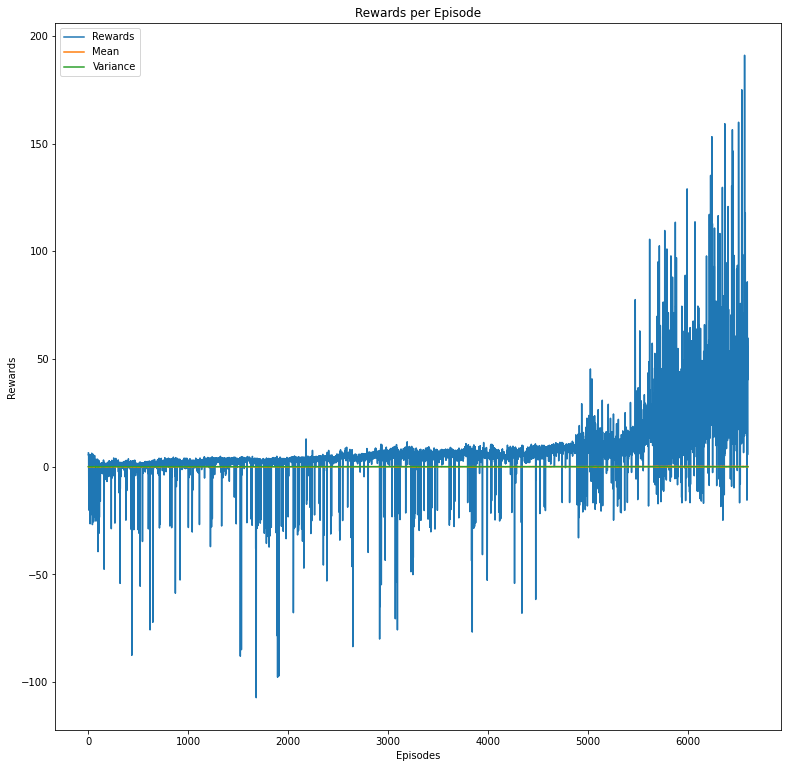

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(13,13))
plt.plot(trainer.rewards, label="Rewards")
plt.plot(trainer.mean_rewards, label="Mean")
plt.plot(trainer.var_rewards, label="Variance")
plt.xlabel("Episodes")
plt.ylabel("Rewards")
plt.title("Rewards per Episode")
plt.legend(loc=0)
plt.show()

In [ ]:
!ls videos/{ENV_NAME}

openaigym.video.0.8333.video000032.meta.json
openaigym.video.0.8333.video000032.mp4
openaigym.video.0.8333.video001682.meta.json
openaigym.video.0.8333.video001682.mp4
openaigym.video.0.8333.video003332.meta.json
openaigym.video.0.8333.video003332.mp4
openaigym.video.0.8333.video004982.meta.json
openaigym.video.0.8333.video004982.mp4


In [ ]:
from google.colab import files
import glob

for file in glob.glob("videos/{}/openaigym.video.*.mp4".format(ENV_NAME)):
  files.download(file)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>